In [39]:
# Display tools
from IPython.display import HTML, display  # For HTML rendering in notebooks
import os 
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import os

def get_dicom_paths(directory_path, label=None, verbose=True):
    """
    Scans a directory for DICOM (.dcm) files and returns their paths.

    Parameters:
    - directory_path (str): Directory to scan for .dcm files
    - label (str, optional): Label for display (e.g., 'train', 'test')
    - verbose (bool): Whether to print the number of files found

    Returns:
    - List[str]: Paths to DICOM files
    """
    dicom_paths = [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.lower().endswith('.dcm')
    ]
    
    if verbose:
        label_text = f" in the '{label}' directory" if label else ""
        print(f" Found {len(dicom_paths)} DICOM files{label_text}.")
    
    return dicom_paths

# --- Define Image Directories ---
    TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
    TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

    # --- Get File Paths ---
    train_img_path = get_dicom_paths(TRAIN_IMG_DIR, label="train")
    test_img_path  = get_dicom_paths(TEST_IMG_DIR, label="test")


 Found 26684 DICOM files in the 'train' directory.
 Found 3000 DICOM files in the 'test' directory.


In [41]:
labels = pd.read_csv(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [42]:
count_normal = len(labels.loc[labels['Target']==0])
count_pnemonia= len(labels.loc[labels['Target']==1])
traing_count=len(train_img_path)

In [ ]:
weight_for_zero =(1/count_normal)*(traing_count)/2.0
weight_for_ones =(1/count_pnemonia)*(traing_count)/2.0

In [44]:
classweight= {0: weight_for_zero,
              1: weight_for_ones}

In [45]:
print("Weights:", classweight)

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


In [46]:
def parseMetadata(dcm):  # corrected from 'paraseMetadata'
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm:  # This forces conversion from lazy RawDataElement to DataElement
        pass

    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords


In [47]:
import pydicom
from tqdm import tqdm

In [48]:


# Step 1: Read DICOM files from paths
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path[:5000])]
test_dcms = [pydicom.dcmread(path) for path in tqdm(test_img_path[:5000])]




100%|██████████| 3000/3000 [00:04<00:00, 680.11it/s]


In [49]:
# Step 2: Parse metadata from DICOM datasets
trainMetaDicts, trainKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
testMetaDicts, testKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(test_dcms)])

100%|██████████| 3000/3000 [00:03<00:00, 875.67it/s]


In [50]:
def createY(df):
    """
    Returns binary labels: 1 if 'SeriesDescription' is 'view: PA', else 0.
    """
    if 'SeriesDescription' not in df.columns:
        raise ValueError("Missing 'SeriesDescription' column in DataFrame.")
    
    return (df['SeriesDescription'] == 'view: PA').astype(int).values


In [51]:
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

train_Y = createY(train_df)
test_Y = createY(test_df)


In [52]:
test_Y

array([1, 1, 1, ..., 1, 1, 1])

In [53]:
def decodeImage(filePath):
    image = pydicom.dcmread(filePath).pixel_array
    image = cv2.resize(image, (64, 64))
    return image / 255.0


In [ ]:

import cv2
import numpy as np

# Get our train x in the correct shape
train_X = []

for filePath in tqdm(train_img_path[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)


train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [01:16<00:00, 65.64it/s] 


In [ ]:
train_X_rgb

array([[[[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.0745098 , 0.0745098 , 0.0745098 ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314]

In [56]:
test_X =[]
for filePath in tqdm(test_img_path[:5000]):
    
    img = decodeImage(filePath)
    test_X.append(img)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:25<00:00, 117.15it/s]


In [ ]:
import matplotlib.pyplot as plt

def plot_score(hist):
    fig, ax = plt.subplots(5, 1, figsize=(10, 20))  # Corrected 'subplot' to 'subplots'
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title(f'Model {met}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()


In [58]:
!pip install tensorflow 

In [59]:
import tensorflow as tf

In [60]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model


In [ ]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

In [62]:
import tensorflow as tf

# Clear, Flexible Exponential Decay Function
def exponential_decay(lr_initial, decay_steps, decay_rate=0.1):
    """
    Returns a function that computes exponentially decaying learning rate.
    
    Parameters:
    - lr_initial: Initial learning rate
    - decay_steps: Controls the rate of decay
    - decay_rate: The base of the exponential decay (default: 0.1)

    Returns:
    - A function that takes an epoch index and returns the decayed learning rate
    """
    def schedule(epoch):
        return lr_initial * decay_rate ** (epoch / decay_steps)
    return schedule

# Define the scheduler function
exponential_decay_fn = exponential_decay(lr_initial=0.01, decay_steps=20)

# Learning Rate Scheduler Callback
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn, verbose=1)

# Model Checkpoint Callback (saves best model only)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="xray_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Early Stopping Callback (restores best weights after patience period)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)


In [26]:
'''
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


'''

'\ndef exponential_decay(lr0, s):\n    def exponential_decay_fn(epoch):\n        return lr0 * 0.1 **(epoch / s)\n    return exponential_decay_fn\n\nexponential_decay_fn = exponential_decay(0.01, 20)\n\nlr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)\n\ncheckpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)\n\nearly_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)\n\n\n'

Baseline Model CNN

In [27]:
import tensorflow as tf

def build_fcnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [28]:
model_fcnn=build_fcnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model_fcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,121 (6.00 MB)

 Trainable params: 1,573,121 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_fcnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [31]:
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100,
                          batch_size = 128,
                          validation_split = 0.15, 
                          class_weight = classweight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler_cb]) # Fit the model


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.5712 - accuracy: 0.5658 - loss: 28.4131 - precision: 0.5680 - recall: 0.7471
Epoch 1: val_loss improved from inf to 2.96462, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - AUC: 0.5729 - accuracy: 0.5675 - loss: 28.0723 - precision: 0.5695 - recall: 0.7482 - val_AUC: 0.7567 - val_accuracy: 0.6880 - val_loss: 2.9646 - val_precision: 0.6369 - val_recall: 0.9852 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.8591 - accuracy: 0.8072 - loss: 1.1026 - precision: 0.7840 - recall: 0.9019
Epoch 2: val_loss improved from 2.96462 to 0.46612, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - AUC: 0.8603 - accuracy: 0.8077 - loss: 1.0898 - precision: 0.7844 - recall: 0.9017 - val_AUC: 0.9319 - val_accuracy: 0.8600 - val_loss: 0.4661 - val_precision: 0.8698 - val_recall: 0.8719 - learning_rate: 0.0089

Epoch 3: LearningRateScheduler setting learning rate to 0.007943282347242816.
Epoch 3/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.9360 - accuracy: 0.8703 - loss: 0.4076 - precision: 0.8494 - recall: 0.9277
Epoch 3: val_loss improved from 0.46612 to 0.39378, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - AUC: 0.9364 - accuracy: 0.8702 - loss: 0.4048 - precision: 0.8491 - recall: 0.9277 - val_AUC: 0.9552 - val_accuracy: 0.8520 - val_loss: 0.3938 - val_precision: 0.7992 - val_recall: 0.9704 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9309 - accuracy: 0.8425 - loss: 0.3649 - precision: 0.8082 - recall: 0.9188
Epoch 4: val_loss improved from 0.39378 to 0.33124, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - AUC: 0.9313 - accuracy: 0.8433 - loss: 0.3631 - precision: 0.8094 - recall: 0.9192 - val_AUC: 0.9626 - val_accuracy: 0.8653 - val_loss: 0.3312 - val_precision: 0.8144 - val_recall: 0.9729 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.9573 - accuracy: 0.8735 - loss: 0.2576 - precision: 0.8446 - recall: 0.9420
Epoch 5: val_loss improved from 0.33124 to 0.26961, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.9572 - accuracy: 0.8732 - loss: 0.2584 - precision: 0.8444 - recall: 0.9417 - val_AUC: 0.9634 - val_accuracy: 0.8947 - val_loss: 0.2696 - val_precision: 0.9554 - val_recall: 0.8448 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.9612 - accuracy: 0.8869 - loss: 0.2484 - precision: 0.8696 - recall: 0.9318
Epoch 6: val_loss did not improve from 0.26961
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.9611 - accuracy: 0.8868 - loss: 0.2481 - precision: 0.8691 - recall: 0.9323 - val_AUC: 0.9622 - val_accuracy: 0.8613 - val_loss: 0.3362 - val_precision: 0.9660 - val_recall: 0.7709 - learning_rate: 0.0056

Epoch 7: LearningRateScheduler setting learning rate to 0.005011872336272724.
Epoch 7/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.9274 - accuracy: 0.8305 - loss: 0.3836 - precision: 0.8162 - recall: 0.8858
Epoch 7: val_

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - AUC: 0.9277 - accuracy: 0.8313 - loss: 0.3815 - precision: 0.8163 - recall: 0.8876 - val_AUC: 0.9685 - val_accuracy: 0.8987 - val_loss: 0.2372 - val_precision: 0.8855 - val_recall: 0.9335 - learning_rate: 0.0050

Epoch 8: LearningRateScheduler setting learning rate to 0.004466835921509631.
Epoch 8/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9587 - accuracy: 0.8876 - loss: 0.2571 - precision: 0.8707 - recall: 0.9323
Epoch 8: val_loss did not improve from 0.23724
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.9587 - accuracy: 0.8874 - loss: 0.2568 - precision: 0.8703 - recall: 0.9326 - val_AUC: 0.9693 - val_accuracy: 0.8920 - val_loss: 0.2640 - val_precision: 0.8525 - val_recall: 0.9680 - learning_rate: 0.0045

Epoch 9: LearningRateScheduler setting learning rate to 0.0039810717055349725.
Epoch 9/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.9667 - accuracy: 0.8935 - loss: 0.2209 - precision: 0.8697 - recall: 0.9480
Epoch 9: val

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - AUC: 0.9525 - accuracy: 0.8518 - loss: 0.2854 - precision: 0.8152 - recall: 0.9394 - val_AUC: 0.9713 - val_accuracy: 0.9187 - val_loss: 0.2184 - val_precision: 0.9197 - val_recall: 0.9310 - learning_rate: 0.0032

Epoch 12: LearningRateScheduler setting learning rate to 0.002818382931264454.
Epoch 12/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.9646 - accuracy: 0.8964 - loss: 0.2365 - precision: 0.8810 - recall: 0.9353
Epoch 12: val_loss did not improve from 0.21839
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.9648 - accuracy: 0.8966 - loss: 0.2355 - precision: 0.8807 - recall: 0.9362 - val_AUC: 0.9726 - val_accuracy: 0.9040 - val_loss: 0.2400 - val_precision: 0.8744 - val_recall: 0.9606 - learning_rate: 0.0028

Epoch 13: LearningRateScheduler setting learning rate to 0.0025118864315095803.
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.9731 - accuracy: 0.9035 - loss: 0.2040 - precision: 0.8768 - recall: 0.9573
Epoch 1

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - AUC: 0.9709 - accuracy: 0.9052 - loss: 0.2118 - precision: 0.8860 - recall: 0.9469 - val_AUC: 0.9737 - val_accuracy: 0.9280 - val_loss: 0.2122 - val_precision: 0.9293 - val_recall: 0.9384 - learning_rate: 0.0018

Epoch 17: LearningRateScheduler setting learning rate to 0.0015848931924611134.
Epoch 17/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUC: 0.9763 - accuracy: 0.9121 - loss: 0.1895 - precision: 0.8899 - recall: 0.9559
Epoch 17: val_loss improved from 0.21217 to 0.21136, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - AUC: 0.9763 - accuracy: 0.9119 - loss: 0.1897 - precision: 0.8898 - recall: 0.9558 - val_AUC: 0.9741 - val_accuracy: 0.9253 - val_loss: 0.2114 - val_precision: 0.9268 - val_recall: 0.9360 - learning_rate: 0.0016

Epoch 18: LearningRateScheduler setting learning rate to 0.0014125375446227546.
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.9679 - accuracy: 0.9025 - loss: 0.2213 - precision: 0.8843 - recall: 0.9454
Epoch 18: val_loss improved from 0.21136 to 0.20888, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - AUC: 0.9680 - accuracy: 0.9025 - loss: 0.2211 - precision: 0.8841 - recall: 0.9455 - val_AUC: 0.9744 - val_accuracy: 0.9240 - val_loss: 0.2089 - val_precision: 0.9330 - val_recall: 0.9261 - learning_rate: 0.0014

Epoch 19: LearningRateScheduler setting learning rate to 0.0012589254117941673.
Epoch 19/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - AUC: 0.9772 - accuracy: 0.9154 - loss: 0.1864 - precision: 0.9037 - recall: 0.9433
Epoch 19: val_loss did not improve from 0.20888
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - AUC: 0.9771 - accuracy: 0.9152 - loss: 0.1866 - precision: 0.9031 - recall: 0.9439 - val_AUC: 0.9735 - val_accuracy: 0.9213 - val_loss: 0.2149 - val_precision: 0.9530 - val_recall: 0.8990 - learning_rate: 0.0013

Epoch 20: LearningRateScheduler setting learning rate to 0.0011220184543019637.
Epoch 20/100
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.9783 - accuracy: 0.9139 - loss: 0.1868 - precision: 0.9025 - recall: 0.9423
Epoch 

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.9680 - accuracy: 0.9059 - loss: 0.2302 - precision: 0.9081 - recall: 0.9159
{'loss': 0.22664691507816315, 'compile_metrics': 0.9120000004768372}


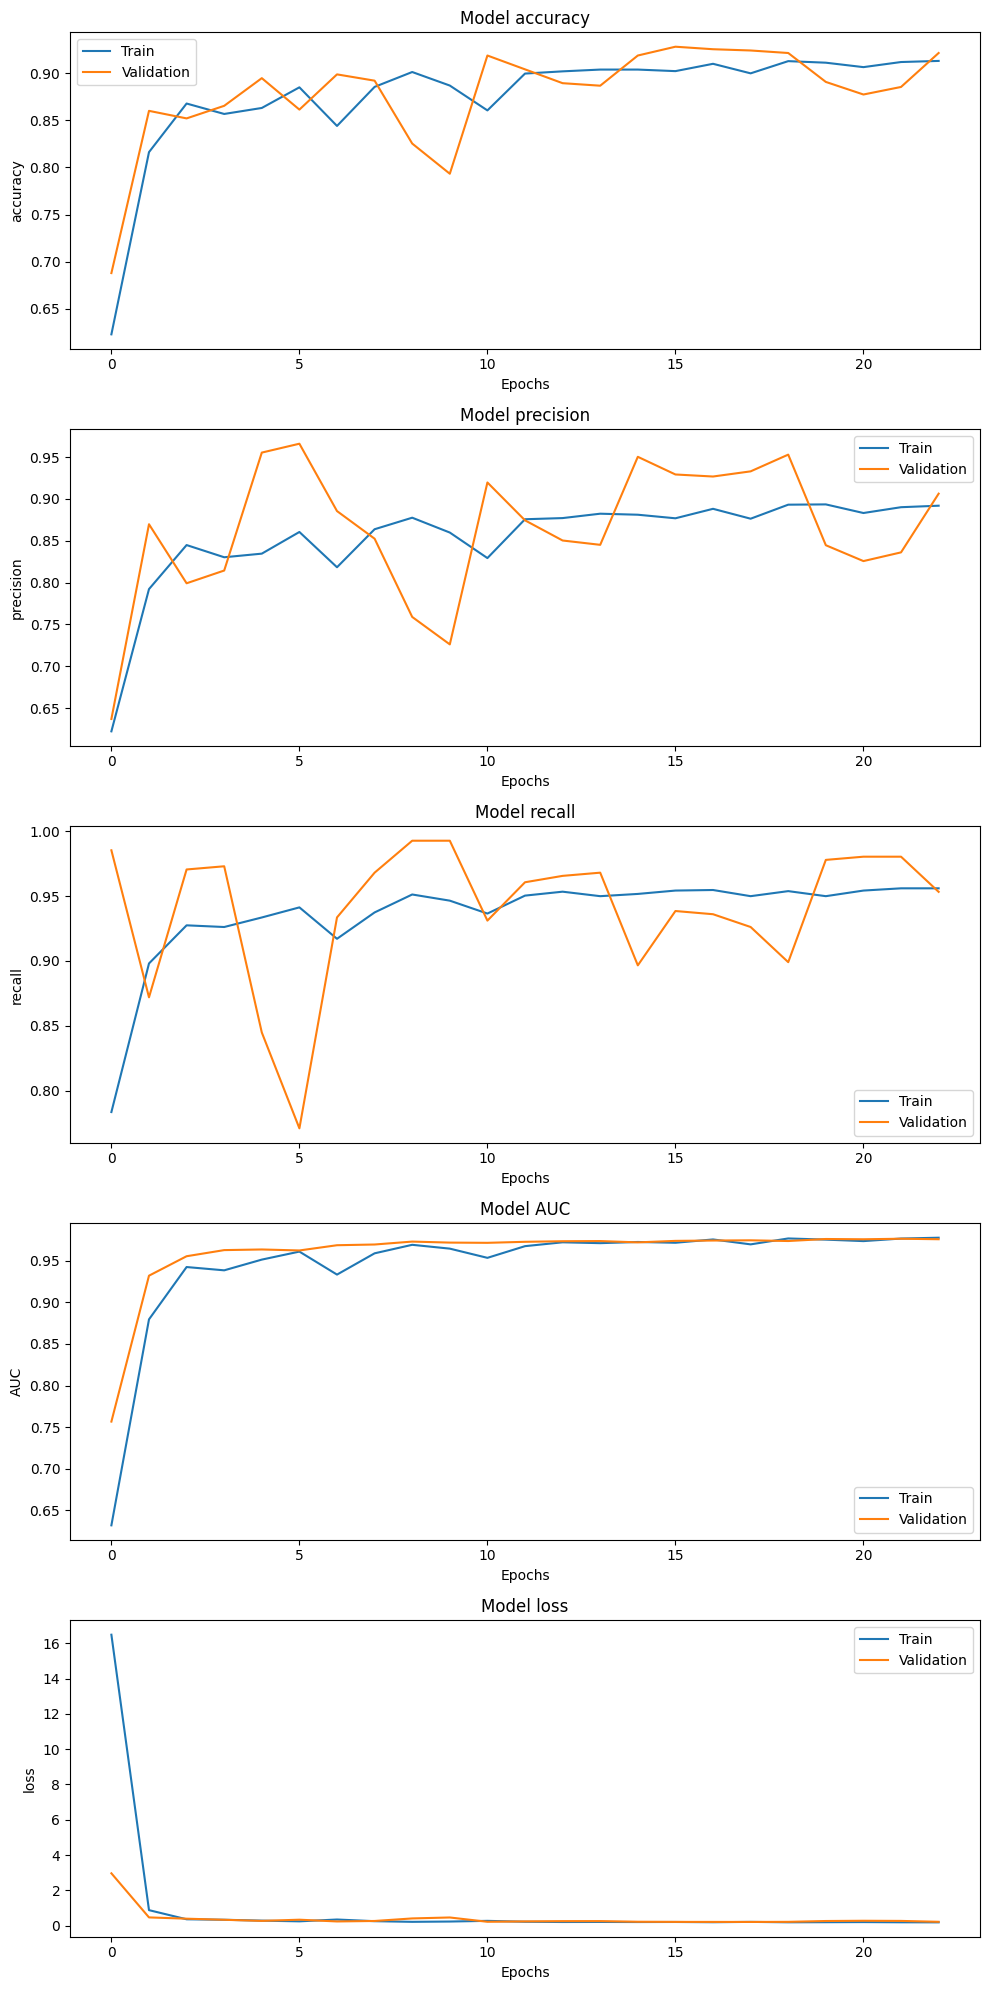

In [32]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plot_score(history_fcnn) # Visualise scores

In [33]:
'''
import tensorflow as tf

def Cust_Cnn_model1():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model
    '''


"\nimport tensorflow as tf\n\ndef Cust_Cnn_model1():\n    model = tf.keras.Sequential([\n        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n\n        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n\n        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),\n        tf.keras.layers.Dropout(0.4),\n\n        tf.keras.layers.Flatten(),\n        tf.keras.layers.Dense(256, activation='relu'),\n        tf.keras.layers.BatchNormalization(),\n        tf.keras.layers.Dropout(0.5),\n\n        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification\n    ])\n    return model\n    "

In [34]:
def Cust_Cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu', input_shape=(64, 64, 3)), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu'), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(), # flatten output of conv
        tf.keras.layers.Dense(512, activation = "relu"), # hidden layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = "relu"), #  output layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    return model

In [35]:

# Instantiate the model
model_cnn = Cust_Cnn_model()


c:\Users\samya\PyCharmProject\Pneumonia-Detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:

# Print model summary
model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,810,273 (6.91 MB)

 Trainable params: 1,808,737 (6.90 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [37]:

# Compile the model
model_cnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)


In [38]:
# Fit model
history_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=50, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classweight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb],
                      verbose=1) # Fit the model


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - AUC: 0.9189 - accuracy: 0.7047 - loss: 0.6756 - precision: 0.8382 - recall: 0.8788
Epoch 1: val_loss did not improve from 0.20888
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 566ms/step - AUC: 0.9187 - accuracy: 0.7067 - loss: 0.6701 - precision: 0.8376 - recall: 0.8790 - val_AUC: 0.5000 - val_accuracy: 0.5413 - val_loss: 59.5195 - val_precision: 0.5413 - val_recall: 1.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/50
18/34 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step - AUC: 0.9343 - accuracy: 0.8574 - loss: 0.3091 - precision: 0.8318 - recall: 0.9177

KeyboardInterrupt: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 0.9708 - accuracy: 0.6636 - loss: 0.5609 - precision: 0.6135 - recall: 0.9928
Test Results: {'loss': 0.5553807020187378, 'compile_metrics': 0.6663333177566528}


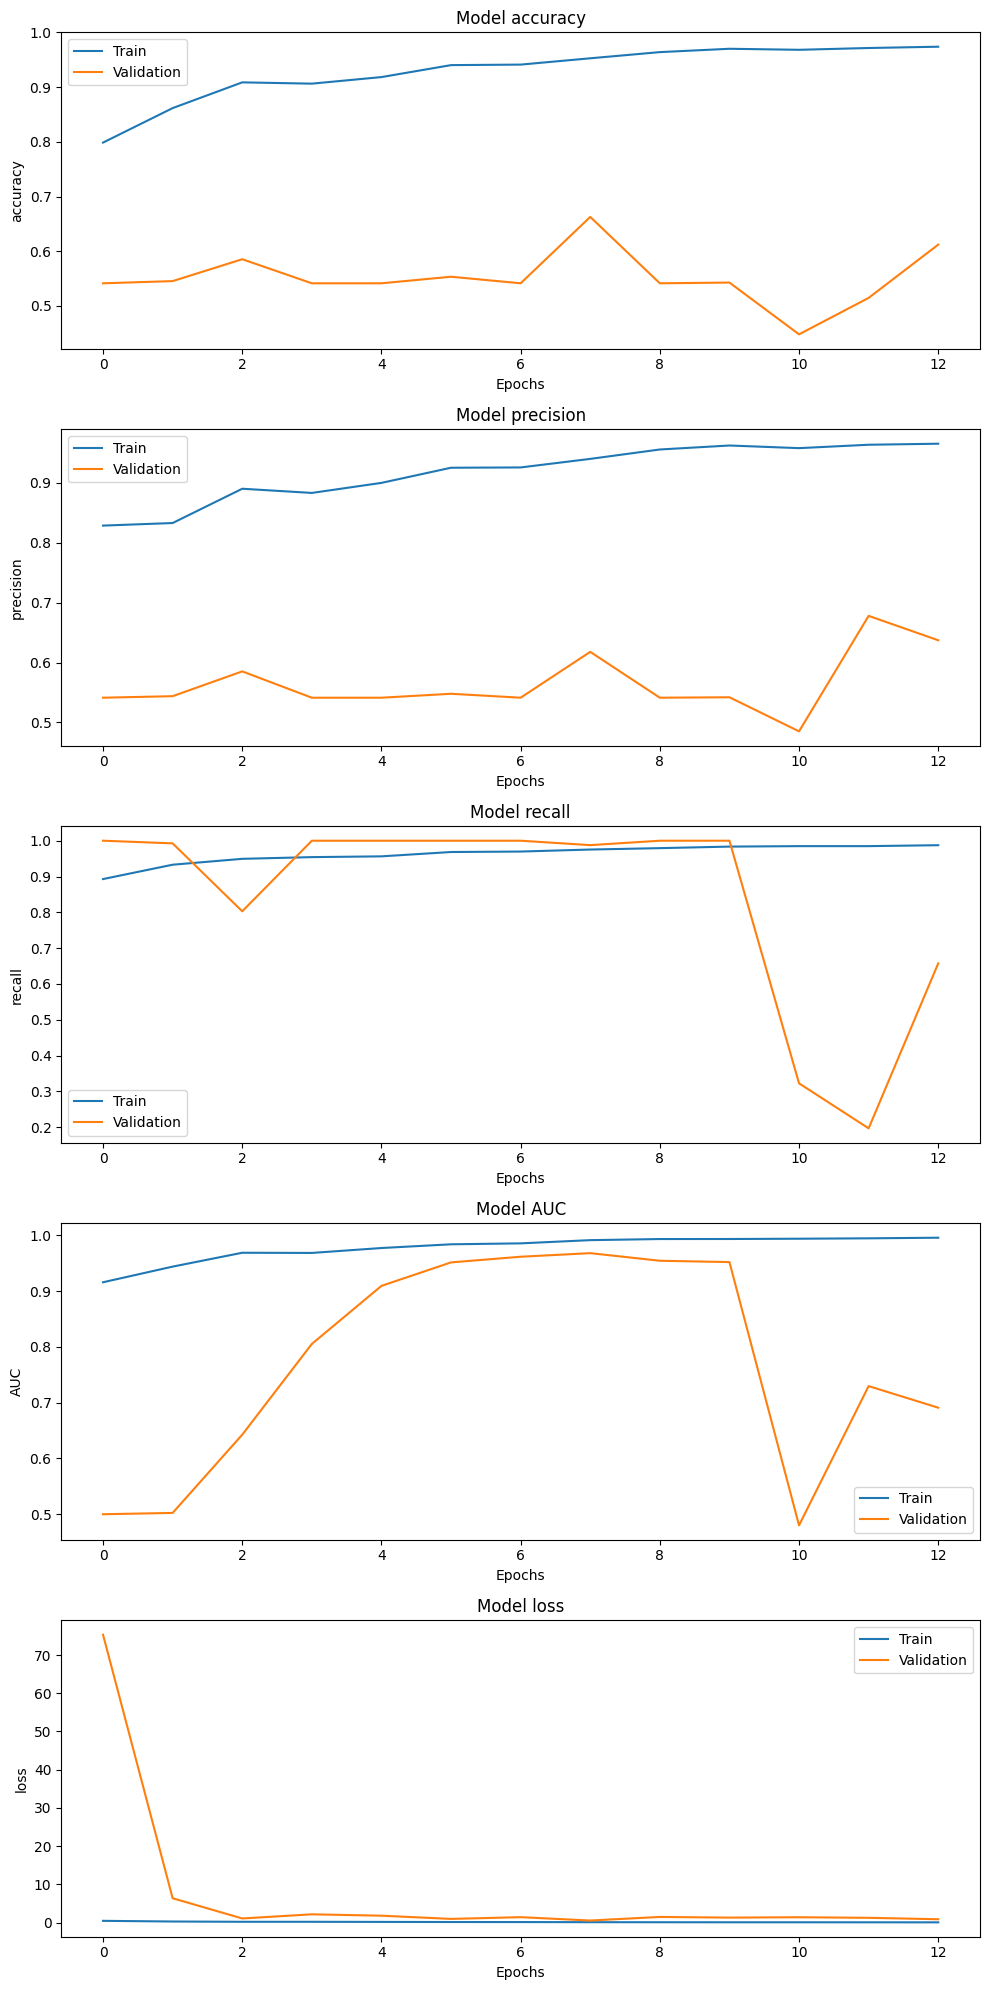

In [ ]:
# Evaluate the trained model on test data
results = model_cnn.evaluate(test_X_rgb, test_Y, verbose=1)

# Convert results to a dictionary for readability
results_dict = dict(zip(model_cnn.metrics_names, results))
print("Test Results:", results_dict)

# Visualize training history
plot_score(history_cnn)


In [ ]:
model = Cust_Cnn_model()

In [ ]:
def build_mn_model():
    model= tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(64, 64, 3)),
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(1, activation = 'sigmoid')
    ])
    model.layers[0].trainable = False
    return model


In [ ]:
# Build and compile mobile net model
model_mn = build_mn_model()
model_mn.summary()
model_mn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

C:\Users\samya\AppData\Local\Temp\ipykernel_3432\1279185705.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(64, 64, 3)),


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_mn = model_mn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 100, 
                          validation_split = 0.15, 
                          class_weight = classweight,
                          batch_size = 128,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler_cb]
                          )


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - AUC: 0.9465 - accuracy: 0.8256 - loss: 0.3157 - precision: 0.6837 - recall: 0.9748
Epoch 1: val_loss improved from 0.22676 to 0.18058, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 558ms/step - AUC: 0.9467 - accuracy: 0.8274 - loss: 0.3134 - precision: 0.6852 - recall: 0.9746 - val_AUC: 0.9794 - val_accuracy: 0.9320 - val_loss: 0.1806 - val_precision: 0.9298 - val_recall: 0.9458 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - AUC: 0.9888 - accuracy: 0.9458 - loss: 0.1230 - precision: 0.9286 - recall: 0.9744
Epoch 2: val_loss improved from 0.18058 to 0.17929, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 436ms/step - AUC: 0.9888 - accuracy: 0.9458 - loss: 0.1230 - precision: 0.9286 - recall: 0.9744 - val_AUC: 0.9834 - val_accuracy: 0.9280 - val_loss: 0.1793 - val_precision: 0.9018 - val_recall: 0.9729 - learning_rate: 0.0089

Epoch 3: LearningRateScheduler setting learning rate to 0.007943282347242816.
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - AUC: 0.9949 - accuracy: 0.9655 - loss: 0.0894 - precision: 0.9540 - recall: 0.9844
Epoch 3: val_loss improved from 0.17929 to 0.13353, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - AUC: 0.9948 - accuracy: 0.9653 - loss: 0.0896 - precision: 0.9538 - recall: 0.9843 - val_AUC: 0.9891 - val_accuracy: 0.9467 - val_loss: 0.1335 - val_precision: 0.9530 - val_recall: 0.9483 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - AUC: 0.9946 - accuracy: 0.9650 - loss: 0.0867 - precision: 0.9552 - recall: 0.9816
Epoch 4: val_loss improved from 0.13353 to 0.12735, saving model to xray_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - AUC: 0.9947 - accuracy: 0.9650 - loss: 0.0867 - precision: 0.9551 - recall: 0.9816 - val_AUC: 0.9906 - val_accuracy: 0.9427 - val_loss: 0.1274 - val_precision: 0.9332 - val_recall: 0.9631 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - AUC: 0.9964 - accuracy: 0.9735 - loss: 0.0743 - precision: 0.9625 - recall: 0.9899
Epoch 5: val_loss did not improve from 0.12735
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step - AUC: 0.9964 - accuracy: 0.9734 - loss: 0.0743 - precision: 0.9624 - recall: 0.9899 - val_AUC: 0.9892 - val_accuracy: 0.9467 - val_loss: 0.1425 - val_precision: 0.9296 - val_recall: 0.9754 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - AUC: 0.9978 - accuracy: 0.9779 - loss: 0.0619 - precision: 0.9675 - recall: 0.9931
Epoch 6

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - AUC: 0.9871 - accuracy: 0.9415 - loss: 0.1462 - precision: 0.9413 - recall: 0.9491
{'loss': 0.1417015939950943, 'compile_metrics': 0.9453333616256714}


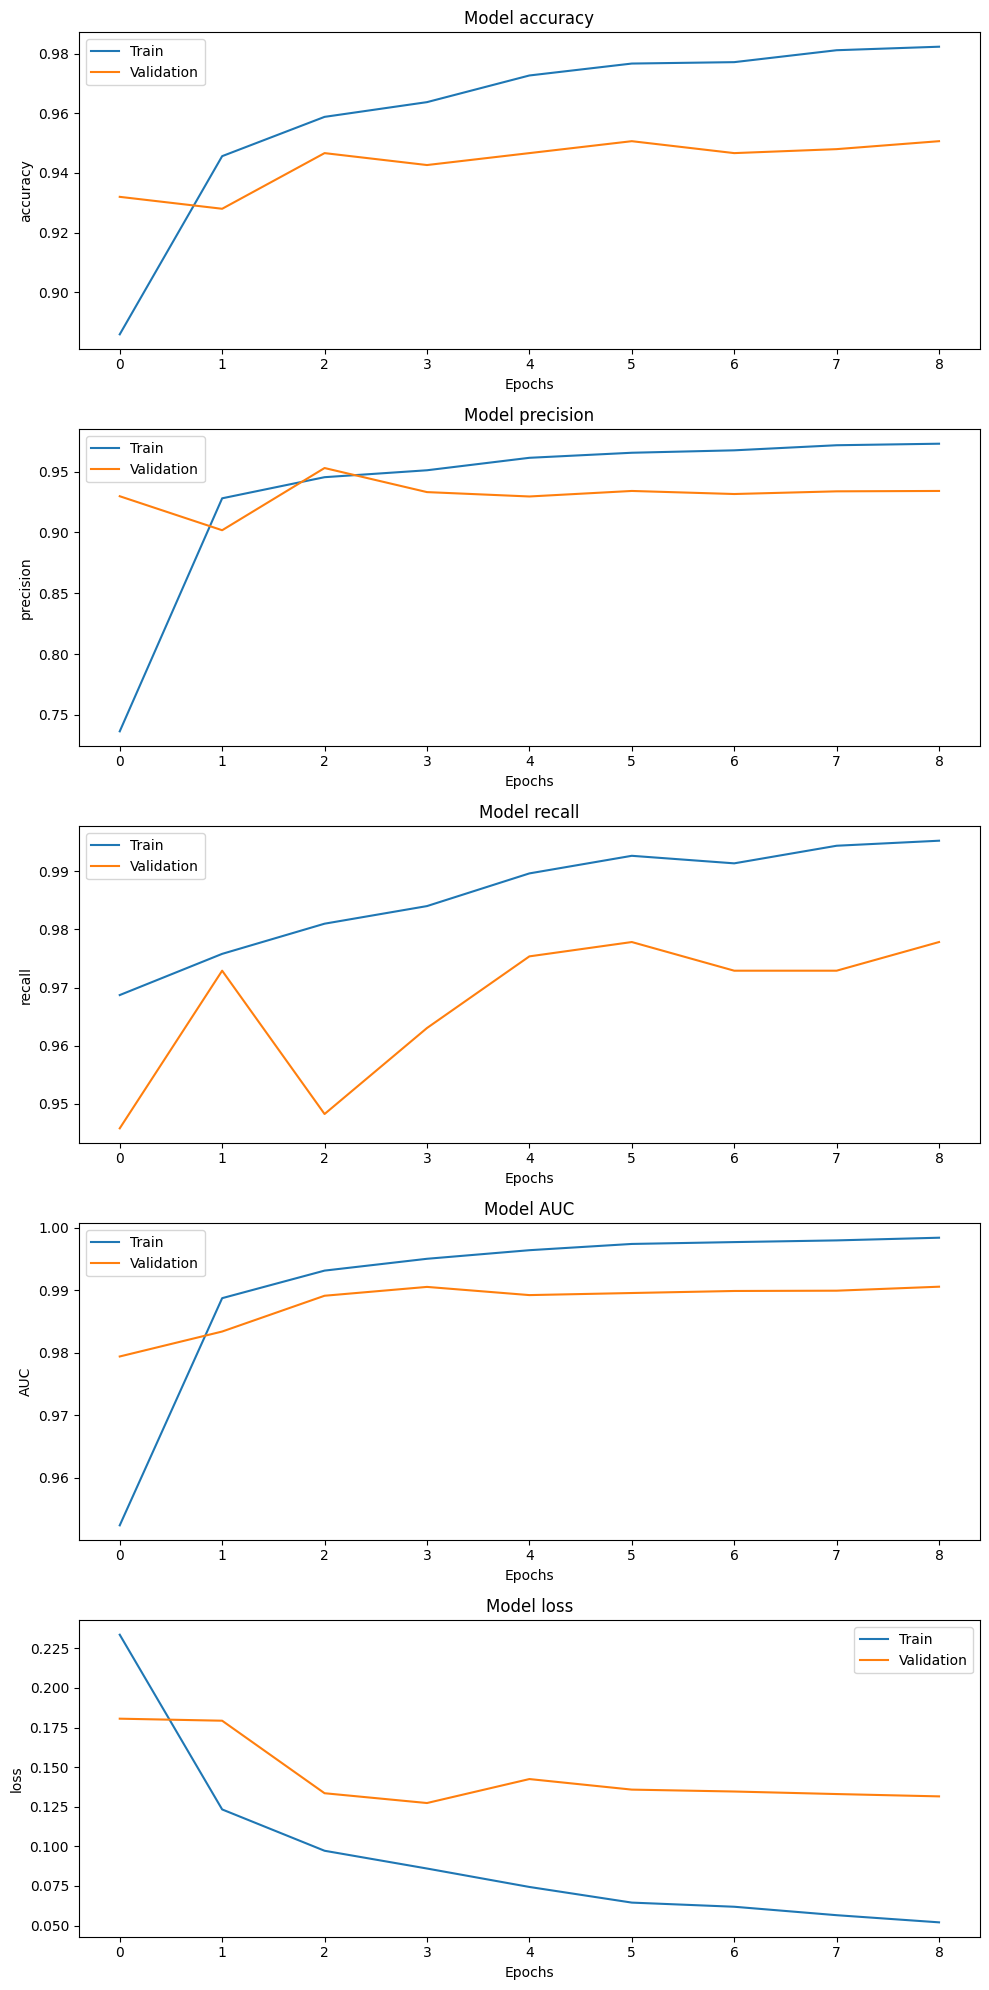

In [ ]:
# Show results and print graphs
results = model_mn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_mn.metrics_names,results))

print(results)
plot_score(history_mn) # Visualise scores

Unet

In [63]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw

# Parameters
image_size = (64, 64)  # Target mask size
csv_path = 'la.csv'  # Path to your CSV file

# Load bounding box annotations
df = labels.copy()

# Filter rows with pneumonia (Target == 1)
df = df[df['Target'] == 1]

# Group bounding boxes by patient ID
grouped = df.groupby('patientId')

# Dictionary to store masks
masks = {}

# Generate binary masks
for patient_id, rows in grouped:
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)

    for _, row in rows.iterrows():
        x, y, w, h = row['x'], row['y'], row['width'], row['height']
        scale_x = image_size[0] / 1024
        scale_y = image_size[1] / 1024
        x1 = int(x * scale_x)
        y1 = int(y * scale_y)
        x2 = int((x + w) * scale_x)
        y2 = int((y + h) * scale_y)
        draw.rectangle([x1, y1, x2, y2], fill=1)

    masks[patient_id] = np.array(mask)


In [64]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2

# --- Configuration ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
CSV_PATH = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv"
OUTPUT_DIR = "npy_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load CSV and filter for annotated images (Target == 1) ---
#df = pd.read_csv(CSV_PATH)
annotated_ids = df[df['Target'] == 1]['patientId'].unique()

# --- Convert DICOM to 64x64 RGB .npy ---
def convert_dicom_to_npy(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    img = ds.pixel_array.astype(np.float32)
    img -= np.min(img)
    img /= np.max(img)
    img *= 255.0
    img = img.astype(np.uint8)
    img_resized = cv2.resize(img, (64, 64))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    return img_rgb

# --- Process and save ---
for patient_id in annotated_ids:
    dicom_file = os.path.join(TRAIN_IMG_DIR, f"{patient_id}.dcm")
    if os.path.exists(dicom_file):
        try:
            img_rgb = convert_dicom_to_npy(dicom_file)
            np.save(os.path.join(OUTPUT_DIR, f"{patient_id}.npy"), img_rgb)
        except Exception as e:
            print(f"Failed to process {patient_id}: {e}")

print("Annotated DICOM images converted to 64x64 RGB .npy files.")


Annotated DICOM images converted to 64x64 RGB .npy files.


In [65]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# --- Configuration ---
IMAGE_DIR = "npy_images"
IMG_SIZE = (64, 64)
BATCH_SIZE = 128
EPOCHS = 10

# --- Select top 5,000 images ---
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.npy')])[:5000]

# --- Load images and masks ---
images, masks_list = [], []
for fname in image_files:
    patient_id = os.path.splitext(fname)[0]
    if patient_id in masks:
        img_path = os.path.join(IMAGE_DIR, fname)
        img = np.load(img_path)
        mask = masks[patient_id]
        images.append(img)
        masks_list.append(mask)

# Convert to numpy arrays
X = np.array(images) / 255.0  # Normalize images
y = np.expand_dims(np.array(masks_list).astype(np.float32), axis=-1)  # Add channel dimension

# --- Split data ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Define U-Net Model ---
def build_unet(input_shape):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D()(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        return conv_block(x, filters)

    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    bottleneck = conv_block(p4, 1024)

    d1 = decoder_block(bottleneck, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    return models.Model(inputs, outputs)

# Build and compile the U-Net model
model = build_unet((IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 256) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 4, 4, 512) │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 4, 4,      │  4,719,616 │ max_pooling2d_6[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 4, 4,      │  9,438,208 │ conv2d_12[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 512) │  2,097,664 │ conv2d_13[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# --- Compile and Train ---
model = build_unet((64, 64, 3))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=METRICS)
history_unet=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS,callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - AUC: 0.5015 - accuracy: 0.6745 - loss: 10814565.0000 - precision: 0.1348 - recall: 0.2591 
Epoch 1: val_loss improved from inf to 0.62500, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1367s 42s/step - AUC: 0.5016 - accuracy: 0.6749 - loss: 10869654.0000 - precision: 0.1350 - recall: 0.2589 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - AUC: 0.4998 - accuracy: 0.8635 - loss: 0.6090 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 2: val_loss improved from 0.62500 to 0.56391, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1248s 39s/step - AUC: 0.4998 - accuracy: 0.8635 - loss: 0.6086 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.5639 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0089

Epoch 3: LearningRateScheduler setting learning rate to 0.007943282347242816.
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - AUC: 0.5011 - accuracy: 0.8639 - loss: 0.5521 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 3: val_loss improved from 0.56391 to 0.52075, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1164s 36s/step - AUC: 0.5011 - accuracy: 0.8639 - loss: 0.5518 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.5207 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - AUC: 0.4961 - accuracy: 0.8643 - loss: 0.5119 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 4: val_loss improved from 0.52075 to 0.49084, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1188s 37s/step - AUC: 0.4963 - accuracy: 0.8643 - loss: 0.5117 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.4908 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - AUC: 0.4996 - accuracy: 0.8642 - loss: 0.4841 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 5: val_loss improved from 0.49084 to 0.46976, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 737s 22s/step - AUC: 0.4996 - accuracy: 0.8642 - loss: 0.4839 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.4698 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - AUC: 0.4985 - accuracy: 0.8634 - loss: 0.4651 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 6: val_loss improved from 0.46976 to 0.45477, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 632s 20s/step - AUC: 0.4987 - accuracy: 0.8634 - loss: 0.4649 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.4548 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0056

Epoch 7: LearningRateScheduler setting learning rate to 0.005011872336272724.
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - AUC: 0.5020 - accuracy: 0.8626 - loss: 0.4518 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 7: val_loss improved from 0.45477 to 0.44388, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 651s 20s/step - AUC: 0.5020 - accuracy: 0.8626 - loss: 0.4517 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.4439 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0050

Epoch 8: LearningRateScheduler setting learning rate to 0.004466835921509631.
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - AUC: 0.5050 - accuracy: 0.8623 - loss: 0.4419 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 8: val_loss improved from 0.44388 to 0.43582, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 619s 19s/step - AUC: 0.5049 - accuracy: 0.8624 - loss: 0.4418 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.4358 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0045

Epoch 9: LearningRateScheduler setting learning rate to 0.0039810717055349725.
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - AUC: 0.4993 - accuracy: 0.8630 - loss: 0.4336 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 9: val_loss improved from 0.43582 to 0.42974, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 622s 19s/step - AUC: 0.4993 - accuracy: 0.8631 - loss: 0.4335 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.4297 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0040

Epoch 10: LearningRateScheduler setting learning rate to 0.003548133892335755.
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - AUC: 0.5002 - accuracy: 0.8633 - loss: 0.4276 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 10: val_loss improved from 0.42974 to 0.42515, saving model to xray_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 645s 20s/step - AUC: 0.5003 - accuracy: 0.8633 - loss: 0.4275 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_accuracy: 0.8624 - val_loss: 0.4252 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0035
Restoring model weights from the end of the best epoch: 10.


In [70]:
pip install pydot


Note: you may need to restart the kernel to use updated packages.


In [75]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file="unet_model.png")


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [76]:
import os
print(os.listdir())


['.git', '.pixi', '.venv', '.vscode', 'backup', 'cfg', 'Cnn.ipynb', 'combined_dicom_paths.csv', 'Dags', 'dataset', 'data_Injection.py', 'data_preprocessing.py', 'data_Visualization.py', 'images', 'npy_images', 'patient_diagnosis.csv', 'pneumonia_model.ipynb', 'README.md', 'tensorflowcnn.ipynb', 'Untitled-1.py', 'when training set is 10000 split it 0.py', 'xray_model.h5', '__pycache__']


In [80]:
# Assuming you have a function named build_unet()
model = build_unet(input_shape=(128, 128, 1))  # or whatever shape you're using

# Now plot the instantiated model
try:
    from tensorflow.keras.utils import plot_model
    from IPython.display import Image, display

    plot_model(model, to_file="unet_model.png", show_shapes=True, show_layer_names=True)
    display(Image(filename="unet_model.png"))
except Exception as e:
    print("Error:", e)


You must install pydot (`pip install pydot`) for `plot_model` to work.
Error: [Errno 2] No such file or directory: 'unet_model.png'


In [83]:
import matplotlib.pyplot as plt

def plot_performance(history):
    metrics = ['accuracy', 'precision', 'recall', 'auc', 'loss']
    plt.figure(figsize=(12, 15))

    for i, metric in enumerate(metrics):
        plt.subplot(len(metrics), 1, i + 1)
        plt.plot(history.history.get(metric, []), label=f'Train {metric}')
        plt.plot(history.history.get('val_' + metric, []), label=f'Val {metric}')
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    
    plt.show()


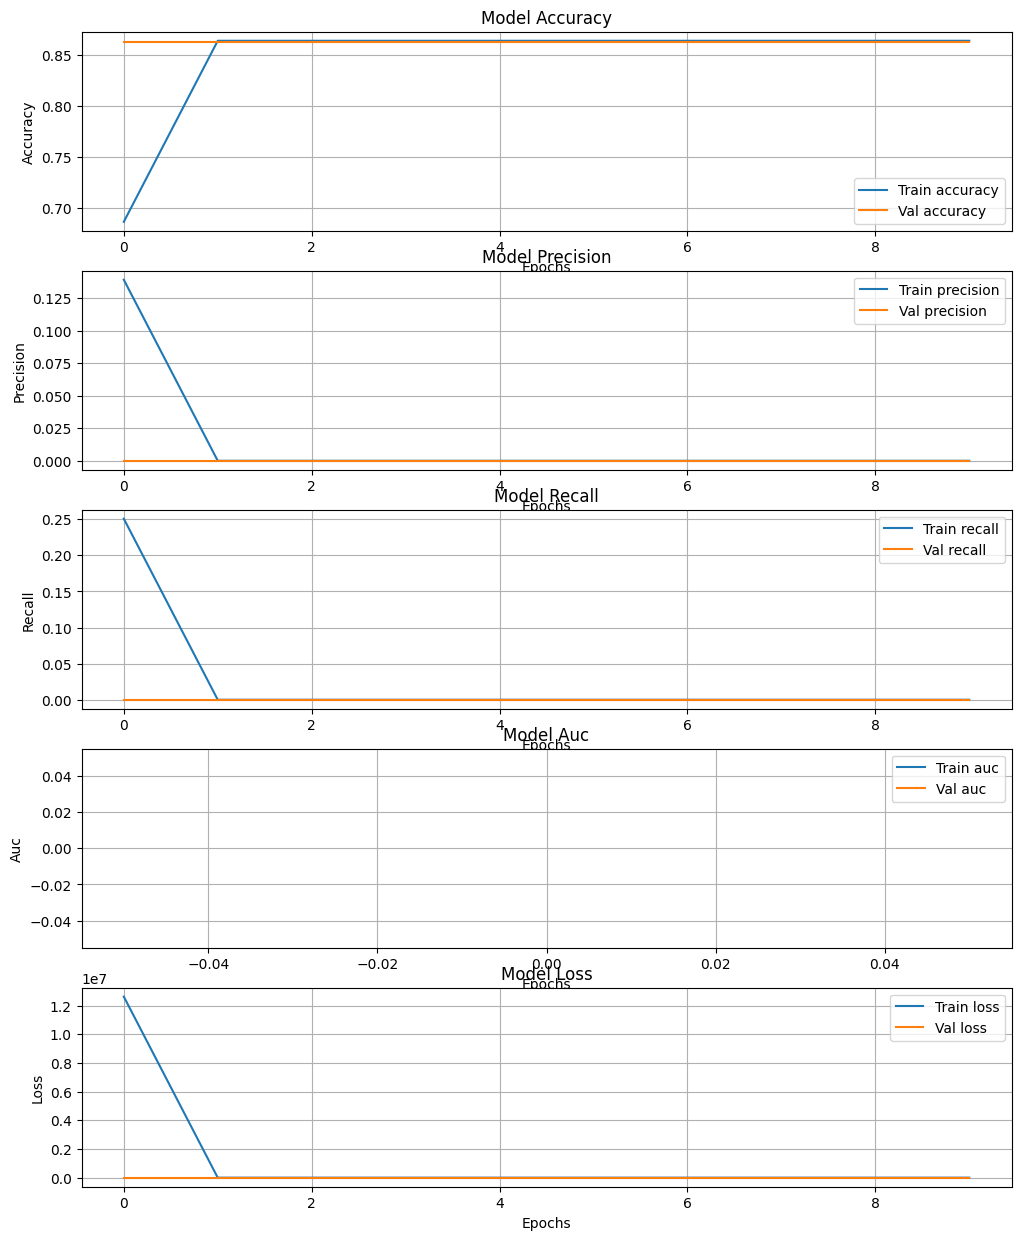

In [84]:
plot_performance(history_unet)

A/B Testing 


In [ ]:
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path)]
trainMetaDicts, _ = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
train_Y = createY(train_df)


100%|██████████| 26684/26684 [00:24<00:00, 1078.03it/s]


In [ ]:
import numpy as np
import random
import pydicom
import cv2
import tensorflow as tf

# Select a random index beyond the first 5000
random_index = random.choice(range(5000, len(train_img_path)))
#random_index = random.choice(range(0, 5000))

# Get the image path and true label
image_path = train_img_path[random_index]
true_label = train_Y[random_index]

# Load and preprocess the DICOM image
def load_and_preprocess_dicom(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    return np.expand_dims(img_rgb, axis=0)  # Add batch dimension

# Prepare image
input_image = load_and_preprocess_dicom(image_path)

# Predict using the trained model
prediction = model_cnn.predict(input_image)[0][0]
predicted_label = int(prediction >= 0.5)

# Output results
print(f"Random image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted probability: {prediction:.4f}")
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Random image path: C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images\ab647d00-1311-4e6a-baf3-f507a55778bd.dcm
True label: 1
Predicted probability: 0.8872
Predicted label: 1


In [ ]:
import numpy as np
import random
import pydicom
import cv2
import tensorflow as tf

# Select a random index beyond the first 5000
random_index = random.choice(range(5000, len(train_img_path)))
#random_index = random.choice(range(0, 5000))

# Get the image path and true label
image_path = train_img_path[random_index]
true_label = train_Y[random_index]

# Load and preprocess the DICOM image
def load_and_preprocess_dicom(path):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array.astype(np.float32)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    return np.expand_dims(img_rgb, axis=0)  # Add batch dimension

# Prepare image
input_image = load_and_preprocess_dicom(image_path)

# Predict using the trained model
prediction = model_fcnn.predict(input_image)[0][0]
predicted_label = int(prediction >= 0.5)

# Output results
print(f"Random image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted probability: {prediction:.4f}")
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Random image path: C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images\dde73260-0a60-49b8-9f69-fda6d4c5f8f0.dcm
True label: 1
Predicted probability: 0.9231
Predicted label: 1
